In [2]:
# Importation 
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import os
import openpyxl
from tsfresh import extract_features, select_features
import matplotlib.pyplot as plt
directory = os.getcwd()

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/opt/anaconda3/lib/python3.8/site-packages/dask/dataframe/utils.py:367: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/opt/anaconda3/lib/python3.8/site-packages/dask/dataframe/utils.py:367: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/opt/anaconda3/lib/python3.8/site-packages/dask/dataframe/utils.py:367: FutureWarning: pandas.UInt64Index is deprecated and will be removed from p

# Intégration données NDVI

<AxesSubplot:title={'center':"Evolution du NDVI moyen sur l'année"}, xlabel='date', ylabel='NDVI'>

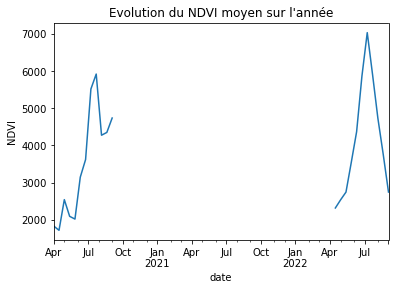

In [3]:
# Importation données NDVI
donnees = pd.read_csv(f"{directory}/donnees/resultats_new.csv", sep = ";", parse_dates = ["date"], dayfirst = True)
donnees = donnees.loc[:,["parcelle","date","NDVI_moy","NDVI_et"]]

# Typage des colonnes
donnees['parcelle'] = donnees['parcelle'].astype('string')
donnees["parcelle"] = donnees["parcelle"].map(lambda x:x.replace('_','').lower())
donnees.columns = donnees.columns.str.replace('NDVI_moy', 'ndvi_moy')
donnees.columns = donnees.columns.str.replace('NDVI_et', 'ndvi_et')
donnees = donnees.set_index('date', drop = False)

donnees["annee"] = donnees["date"].dt.year # on utilise cette colonne annee pour les jointures pr récup le peuplement et le précédent
donnees["annee"] = donnees["annee"].astype('string')

# Graphe évolution NDVI moyenné par mois
# sns.lineplot(x="date", y="ndvi", data=donnees, hue="parcelle", legend = False)
donnees["ndvi_moy"].resample("2W").mean().plot(title = "Evolution du NDVI moyen sur l'année", ylabel = "NDVI")

# Intégration du target (peuplement)

In [4]:
peuplement_1 = pd.read_excel(f"{directory}/donnees/peuplement/donnees2022_BA-2.xlsx", engine='openpyxl', parse_dates = ["date"])
peuplement_1 = peuplement_1.loc[:,["parcelle","date","peuplement"]]
peuplement_1["annee"] = peuplement_1['date'].dt.year
peuplement_1 = peuplement_1.drop(["date"], axis=1)

peuplement_2 = pd.read_excel(f"{directory}/donnees/peuplement/Placette_TRN22_beauce.xlsx", engine='openpyxl', parse_dates = ["date_obs"])
peuplement_2 = peuplement_2.loc[:,["numero_parcelle","date_obs","peuplement"]]
peuplement_2.columns = peuplement_2.columns.str.replace('numero_parcelle', 'parcelle')
peuplement_2.columns = peuplement_2.columns.str.replace('date_obs','date')
peuplement_2["annee"] = peuplement_2['date'].dt.year
peuplement_2 = peuplement_2.drop(["date"], axis=1)
peuplement_2 = peuplement_2[peuplement_2["parcelle"] != "80_22"] # la dernière ligne a un NA dans col peuplement

peuplement_3 = pd.read_csv(f"{directory}/donnees/peuplement/crop_pro.csv", decimal = ".", sep = ";", encoding = "ISO-8859-1")
peuplement_3 = peuplement_3.loc[:,["ID","annee","viables"]]
peuplement_3.columns = peuplement_3.columns.str.replace('ID', 'parcelle')
peuplement_3.columns = peuplement_3.columns.str.replace('viables', 'peuplement')

peuplement_4 = pd.read_csv(f"{directory}/donnees/peuplement/comptages_yonne_2022.csv", decimal = ",", sep = ";", encoding = "ISO-8859-1", parse_dates = ["date"])
peuplement_4 = peuplement_4.loc[:,["id_parcelle","agri_parcelle","date","peuplement"]]
peuplement_4["parcelle"] = peuplement_4["id_parcelle"].astype(str) + peuplement_4["agri_parcelle"].astype(str)
peuplement_4["parcelle"] = peuplement_4["parcelle"].map(lambda x:x.replace('_','').lower())
peuplement_4["annee"] = pd.Series([2022 for i in range(peuplement_4.shape[0])])
peuplement_4 = peuplement_4.drop(["id_parcelle","agri_parcelle","date"], axis=1)


peuplement = pd.concat([peuplement_1, peuplement_2, peuplement_3, peuplement_4], axis=0)
peuplement["parcelle"] = peuplement["parcelle"].map(lambda x:x.replace('_','').lower())
peuplement['parcelle'] = peuplement['parcelle'].astype('string')
peuplement["annee"] = peuplement["annee"].astype('int')
peuplement = peuplement.groupby(["parcelle","annee"]).agg({"peuplement":["mean"]})
peuplement.columns = peuplement.columns.droplevel()
peuplement.columns = ["peuplement"]
peuplement = peuplement.reset_index()

# Intégration aux données NDVI
peuplement['annee'] = peuplement['annee'].astype('string')

donnees = donnees.merge(peuplement,on=['parcelle','annee'],how='left')

donnees['parcelle'] = donnees['parcelle'].astype('string')



<ipython-input-4-5717abe5103e>:19: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  peuplement_4 = pd.read_csv(f"{directory}/donnees/peuplement/comptages_yonne_2022.csv", decimal = ",", sep = ";", encoding = "ISO-8859-1", parse_dates = ["date"])


In [9]:
peuplement_3.parcelle.unique()

array(['1_pc_2018', '2_pc_2018', '3_pc_2018', '4_pc_2018', '5_pc_2018',
       '6_pc_2018', '7_pc_2018', '8_pc_2018', '9_pc_2018', '10_pc_2018',
       '11_pc_2018', '12_pc_2018', '13_pc_2018', '14_pc_2018',
       '15_pc_2018', '16_pc_2018', '17_pc_2018', '18_pc_2018',
       '19_pc_2018', '20_pc_2018', '21_pc_2018', '22_pc_2018',
       '23_pc_2018', '24_pc_2018', '25_pc_2018', '26_pc_2018',
       '27_pc_2018', '28_pc_2018', '29_pc_2018', '30_pc_2018',
       '31_pc_2018', '32_pc_2018', '33_pc_2018', '34_pc_2018',
       '35_pc_2018', '36_pc_2018', '37_pc_2018', '38_pc_2018',
       '39_pc_2018', '40_pc_2018', '41_pc_2018', '44_pc_2018',
       '45_pc_2018', '48_pc_2018', '49_pc_2018', '91_Gers_2019',
       '68_PC_2019', '64_PC_2019', '130_Gers_2019', '57_PC_2019',
       '36_PC_2019', '129_Gers_2019', '121_Gers_2019', '76_PC_2019',
       '99_PC_2019', '18_PC_2019', '133_Gers_2019', '14_PC_2019',
       '69_PC_2019', '95_Gers_2019', '20_PC_2019', '31_Gers_2019',
       '38_PC_2019

In [8]:
donnees.parcelle.unique()

<StringArray>
[     'aubiet11',      'aubiet22',    'coulonges2',       'fdgeda1',
       'fdgeda2',       'fdgeda6',       'fdgeda7',       'fdgeda8',
  'lamagistere3',       'tiagen1',     'tiravard1',   'tirosieres1',
   'tirosieres3',   'tirosieres4',    'tivillers5',    'tivillers6',
    'tivillers7',    'tivillers8',          '0222',          '0522',
          '0622',          '1722',          '2822',          '2922',
          '3822',          '4222',          '4422',          '4522',
          '4722',          '5222',          '5322',          '5422',
          '6222',          '6322',          '6622',          '6722',
          '7122',          '7322',          '7422',          '7522',
          '7622',          '7822',          '8022',          '8222',
          '8822', '1fonteneilles',       '2saison',     '3bretagne',
       '4horton',     '5bretagne',       '6philbe',       '7philbe',
       '8philbe', '9fonteneilles',      '10horton',    '11faucheux',
     '12jourlin',   

<AxesSubplot:xlabel='parcelle,annee'>

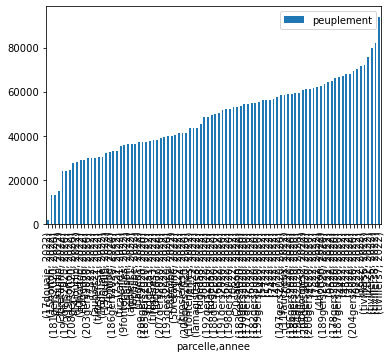

In [10]:
# Graphique pour voir les valeurs de peuplement
donnees.groupby(["parcelle","annee"]).agg({"peuplement":"first"}).dropna(axis=0).sort_values("peuplement").plot.bar()

In [207]:
# Code pour identifiere des parcelles sans valeur de peuplement
donnees.groupby(["parcelle","annee"]).agg({"peuplement":"first", "ndvi_moy":"first"})[0:30]

,peuplement,ndvi_moy
parcelle,,
0222,70400.000000,3255
0522,64800.000000,3466
0622,52800.000000,3165
10horton,28800.000000,2097
11faucheux,58666.666667,2022
12jourlin,14666.666667,2364
13jourlin,32333.333333,2592
14jourlin,28000.000000,2032
15horton,12952.693526,2275


# Intégration des images NDVI en matrices de pixels

In [6]:
import rasterio as rio
path_image = f"{directory}/donnees/NDVI parcelle new/S2A2A_20200403_094_209gers2020_NDVI_10.tif" 
dataset = rio.open(path_image)
Z = dataset.read(1)


donnees_pixel = pd.DataFrame({'parcelle':'ini', 'date':'ini', 'ndvi':[1.1], 'x':[1], 'y':[1]})
donnees_pixel['date'] = donnees_pixel['date'].astype('string')
donnees_pixel['parcelle'] = donnees_pixel['parcelle'].astype('string')
cpt = 0
for image_name in os.listdir(f"{directory}/donnees/NDVI parcelle new"):
    cpt += 1
    if cpt % 100 == 0:
        print("cpt : ",cpt)
    matrice_pixels = rio.open(f"{directory}/donnees/NDVI parcelle new/{image_name}").read(1)

    for i in range(matrice_pixels.shape[0]):
        for j in range(matrice_pixels.shape[1]):
            if matrice_pixels[i,j] > -1000000:
                donnees_pixel = pd.concat([donnees_pixel, pd.DataFrame({'parcelle':image_name[19:-12], 'date':image_name[6:14], 'ndvi':matrice_pixels[i,j], 'x':[j], 'y':[i]})], axis=0)

donnees_pixel = donnees_pixel.iloc[1:]
donnees_pixel.head()
    

# Après faut convertir toutes les dates

cpt :  100


KeyboardInterrupt: 

In [276]:
donnees_pixel.loc[(donnees_pixel.parcelle == "6722") & (donnees_pixel.date == "20220813"),:]

,parcelle,date,ndvi,x,y
0,6722,20220813,7537.258301,16,0
0,6722,20220813,6271.835449,17,0
0,6722,20220813,7501.742188,15,1
0,6722,20220813,5997.862305,16,1
0,6722,20220813,5024.150391,17,1
...,...,...,...,...,...
0,6722,20220813,3584.543457,28,38
0,6722,20220813,3380.028076,29,38
0,6722,20220813,3283.556641,30,38
0,6722,20220813,3775.975098,28,39


In [ ]:
l = []
for image_name in listdir(f"{directory}/donnees/NDVI parcelle new")[0:10]:
    matrice_pixels = rio.open(f"{directory}/donnees/NDVI parcelle new/{image_name}").read(1)
    l.append(matrice_pixels.shape)
l

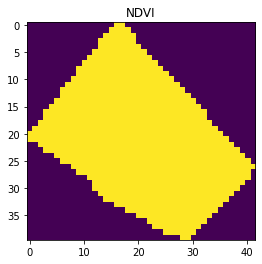

In [270]:
import rasterio as rio
path_image = f"{directory}/donnees/NDVI parcelle new/S2B2A_20220813_051_6722_NDVI_10.tif" 
Z = rio.open(path_image).read(1)

plt.imshow(Z)
plt.title("NDVI")
plt.show()

In [265]:
donnees_pixel.iloc[:].shape

(9441, 5)

# Intégration des résultats du clustering des pixels de toutes les parcelles

In [50]:
resultats_clustering = pd.read_csv(f"{directory}/donnees/resultats_pixel_all_parcelle/resultats_clustering_all_parcelle.csv")
resultats_clustering = resultats_clustering.drop(['Unnamed: 0','x','y'], axis=1)
resultats_clustering["parcelle"] = resultats_clustering["parcelle"].map(lambda x:x.replace('_','').lower())

peuplement["parcelle"] = peuplement["parcelle"] + '.' + peuplement["annee"]
peuplement = peuplement.drop(['annee'], axis=1)

resultats_clustering = resultats_clustering.merge(peuplement,on=['parcelle'],how='left')

resultats_clustering = resultats_clustering.groupby(["parcelle", "num_cluster"]).agg({"num_cluster":"count", "peuplement":"mean"})
resultats_clustering.columns = resultats_clustering.columns.str.replace('num_cluster', 'count_cluster')
resultats_clustering = resultats_clustering.reset_index()
resultats_clustering = pd.pivot(resultats_clustering, index = 'parcelle', columns = 'num_cluster', values = ['count_cluster','peuplement'])
resultats_clustering.columns = resultats_clustering.columns.droplevel()
resultats_clustering = resultats_clustering.set_axis(['clus_0','clus_1', 'clus_2', 'peupl_0', 'peupl_1', 'peupl_2'], axis=1, inplace=False)
resultats_clustering.peupl_1 = resultats_clustering.peupl_1.fillna(resultats_clustering.peupl_2)
resultats_clustering = resultats_clustering.drop(['peupl_2','peupl_0'], axis=1)
resultats_clustering.clus_0 = resultats_clustering.clus_0.fillna(0)
resultats_clustering.clus_1 = resultats_clustering.clus_1.fillna(0)
resultats_clustering.clus_2 = resultats_clustering.clus_2.fillna(0)
resultats_clustering = resultats_clustering.dropna(axis = 0)
resultats_clustering["proportion_clus_0"] = resultats_clustering.clus_0 / (resultats_clustering.clus_0 + resultats_clustering.clus_1 + resultats_clustering.clus_2)
resultats_clustering["proportion_clus_1"] = resultats_clustering.clus_1 / (resultats_clustering.clus_0 + resultats_clustering.clus_1 + resultats_clustering.clus_2)
resultats_clustering["proportion_clus_2"] = resultats_clustering.clus_2 / (resultats_clustering.clus_0 + resultats_clustering.clus_1 + resultats_clustering.clus_2)
resultats_clustering = resultats_clustering.drop(['clus_0','clus_1', 'clus_2'], axis=1)
resultats_clustering.columns = resultats_clustering.columns.str.replace('peupl_1', 'peuplement')

# Attention ne pas lancer plsrs fois cette cellule

<AxesSubplot:xlabel='proportion_clus_0', ylabel='peuplement'>

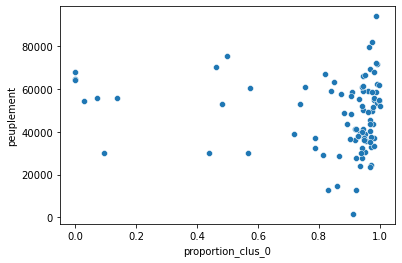

In [114]:
resultats_clustering.dtypes

sns.scatterplot(data = resultats_clustering, x = 'proportion_clus_0', y = 'peuplement')



# Intégration des résultats du clustering des pixels par parcelle avec clusters généralisés

In [36]:
peuplement_tmp = peuplement.copy()

resultats_clustering = pd.read_csv(f"{directory}/donnees/resultats_clustering_par_parcelle/resultats_clustering_par_parcelle_cluster_generalise.csv")
resultats_clustering = resultats_clustering.drop(['Unnamed: 0','x','y'], axis=1)
resultats_clustering.columns = resultats_clustering.columns.str.replace('cluster_generalise', 'num_cluster')
resultats_clustering["parcelle"] = resultats_clustering["parcelle"].map(lambda x:x.replace('_','').lower())
# resultats_clustering["parcelle"] = resultats_clustering["parcelle"].str.split('.',0)[0] + '.' + resultats_clustering["parcelle"].split('.')[1]
# resultats_clustering["parcelle"] = pd.Series([ligne[0]+'.'+ligne[1] for ligne in resultats_clustering["parcelle"].str.split('.',0)])

peuplement_tmp["parcelle"] = peuplement_tmp["parcelle"] + '.' + peuplement_tmp["annee"]
peuplement_tmp = peuplement_tmp.drop(['annee'], axis=1)

resultats_clustering = resultats_clustering.merge(peuplement_tmp,on=['parcelle'],how='left')

resultats_clustering = resultats_clustering.groupby(["parcelle", "num_cluster"]).agg({"num_cluster":"count", "peuplement":"mean"})
resultats_clustering.columns = resultats_clustering.columns.str.replace('num_cluster', 'count_cluster')
resultats_clustering = resultats_clustering.reset_index()
resultats_clustering = pd.pivot(resultats_clustering, index = 'parcelle', columns = 'num_cluster', values = ['count_cluster','peuplement'])
resultats_clustering.columns = resultats_clustering.columns.droplevel()
resultats_clustering = resultats_clustering.set_axis(['clus_0','clus_1', 'clus_2', 'peupl_0', 'peupl_1', 'peupl_2'], axis=1)
resultats_clustering.peupl_1 = resultats_clustering.peupl_1.fillna(resultats_clustering.peupl_2)
resultats_clustering = resultats_clustering.drop(['peupl_2','peupl_0'], axis=1)
resultats_clustering.clus_0 = resultats_clustering.clus_0.fillna(0)
resultats_clustering.clus_1 = resultats_clustering.clus_1.fillna(0)
resultats_clustering.clus_2 = resultats_clustering.clus_2.fillna(0)
resultats_clustering = resultats_clustering.dropna(axis = 0)
resultats_clustering["proportion_clus_0"] = resultats_clustering.clus_0 / (resultats_clustering.clus_0 + resultats_clustering.clus_1 + resultats_clustering.clus_2)
resultats_clustering["proportion_clus_1"] = resultats_clustering.clus_1 / (resultats_clustering.clus_0 + resultats_clustering.clus_1 + resultats_clustering.clus_2)
resultats_clustering["proportion_clus_2"] = resultats_clustering.clus_2 / (resultats_clustering.clus_0 + resultats_clustering.clus_1 + resultats_clustering.clus_2)
resultats_clustering = resultats_clustering.drop(['clus_0','clus_1', 'clus_2'], axis=1)
resultats_clustering.columns = resultats_clustering.columns.str.replace('peupl_1', 'peuplement')


In [39]:
resultats_clustering

,peuplement,proportion_clus_0,proportion_clus_1,proportion_clus_2
parcelle,,,,
0222.2022,70400.000000,0.144928,0.246377,0.608696
0522.2022,64800.000000,0.159817,0.381279,0.458904
0622.2022,52800.000000,0.132132,0.357357,0.510511
10horton.2022,28800.000000,0.121294,0.366577,0.512129
11faucheux.2022,58666.666667,0.063102,0.519786,0.417112
...,...,...,...,...
tirosieres4.2022,41200.000000,0.100917,0.545872,0.353211
tivillers5.2022,79600.000000,0.150507,0.321274,0.528220
tivillers6.2022,72000.000000,0.052868,0.434196,0.512936


<AxesSubplot:xlabel='proportion_clus_2', ylabel='peuplement'>

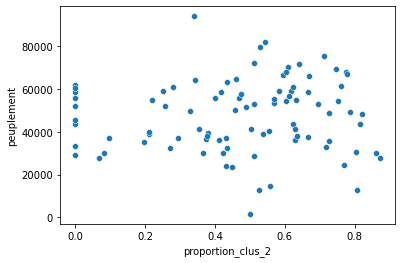

In [63]:
# sns.scatterplot(data = resultats_clustering, x = 'proportion_clus_0', y = 'peuplement')
# sns.scatterplot(data = resultats_clustering, x = 'proportion_clus_1', y = 'peuplement')
sns.scatterplot(data = resultats_clustering, x = 'proportion_clus_2', y = 'peuplement')

In [60]:
# Entrainement d'un modèle --> Marche pas

from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn import linear_model
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.pipeline import make_pipeline
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import RandomForestRegressor

X = resultats_clustering.loc[:,['proportion_clus_0','proportion_clus_1','proportion_clus_2']]
y = resultats_clustering.loc[:,'peuplement']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# # Régression ElasticNet - features de select_features
# param_grid = {'l1_ratio': [0,0.1,0.2,0.3,0.4,0.5,0.6,0.8,0.9,1]}
# scores_train = []
# for param in param_grid["l1_ratio"]:
#     mod = ElasticNet(l1_ratio = param, max_iter = 100000, tol = 1)
#     scores_train.append(cross_val_score(mod, X_train, y_train, cv = 5, scoring = "r2").mean())
# print(scores_train)

# Régression ElasticNet - features issues de l'ACP
# param_grid = {'l1_ratio': [0,0.1,0.2,0.3,0.4,0.5,0.6,0.8,0.9,1]}
# scores_train = []
# for param in param_grid["l1_ratio"]:
#     mod = ElasticNet(l1_ratio = param, max_iter = 1000000, tol = 0.001)
#     scores_train.append(cross_val_score(mod, X_train_pca, y_train_pca, cv = 5, scoring = "r2").mean())
# print(scores_train)


# Régression Lasso - features de select_features
# param_grid = {'alpha': [0,0.1,0.2,0.3,0.4,0.5,0.6,0.8,0.9,1]}
# scores_train = []
# for param in param_grid["alpha"]:
#     mod = ElasticNet(alpha = param,max_iter = 80000, tol = 0.1)
#     scores_train.append(cross_val_score(mod, X_train, y_train, cv = 5, scoring = "r2").mean())
# print(scores_train)

# Régression Lasso - vec features issues de l'ACP
# param_grid = {'alpha': [0.1,1,10,100]}
# scores_train = []
# for param in param_grid["alpha"]:
#     mod = linear_model.Lasso(alpha = param, max_iter = 1000000, tol =0.11)
#     scores_train.append(cross_val_score(mod, X_train_pca, y_train_pca, cv = 5, scoring = "r2").mean())
# print(scores_train)


# # Régression PLS - features de select_features
# scores_train = []
# param_grid = {'n_components': [1,2,3,4,5,6]}
# for param in param_grid["n_components"]:
#     pls = PLSRegression(n_components = param ,max_iter = 10000, tol = 0.01)
#     scores_train.append(cross_val_score(pls, X_train, y_train, cv = 5, scoring = "r2").mean())
# print(scores_train)

# # Random Forest Regressor
# scores_train = []
# param_grid = {'criterion': ["squared_error", "absolute_error", "friedman_mse", "poisson"]}
# for param in param_grid["criterion"]:
#     rfr = RandomForestRegressor(criterion = param)
#     scores_train.append(cross_val_score(rfr, X_train, y_train, cv = 5, scoring = "r2").mean())
# print(scores_train)

# # SVR
# scores_train = []
# param_grid = {'C': [0.01, 1, 100]}
# for param in param_grid["C"]:
#     # print(param)
#     svr = SVR(C = param, gamma = 'auto')
#     scores_train.append(cross_val_score(svr, X_train, y_train, cv = 5, scoring = "r2").mean())
# print(scores_train)

# # KNN
# scores_train = []
# param_grid = {'n_neighbors': [1,5,10,15]}
# for param in param_grid["n_neighbors"]:
#     # print(param)
#     knn = KNeighborsRegressor(n_neighbors = param)
#     scores_train.append(cross_val_score(knn, X_train, y_train, cv = 5, scoring = "r2").mean())
# print(scores_train)



ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py", line 660, in fit
    super().fit(X, Y)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py", line 251, in fit
    raise ValueError(
ValueError: `n_components` upper bound is 3. Got 4 instead. Reduce `n_components`.


# Intégration des données cultures précédentes

In [9]:
# Fichiers avec données cultures précédentes
filenames = glob.glob(f"{directory}/donnees/precedents/*.csv")

# tableau où on agrège toutes les données cultures précédentes
donnees_precedent = pd.read_csv(filenames[0], sep = ";")

for file in filenames[1:]:
    donnees_precedent_tmp = pd.read_csv(file, sep = ";")
    donnees_precedent = pd.concat([donnees_precedent,donnees_precedent_tmp], axis = 0)

donnees_precedent = donnees_precedent.drop(["ID_PARCEL"], axis = 1)

# Typage des colonnes
donnees_precedent.columns = donnees_precedent.columns.str.replace('CODE_CULTU', 'precedent')
donnees_precedent['precedent'] = donnees_precedent['precedent'].astype('string')
donnees_precedent['campagne'] = donnees_precedent['campagne'].astype('string')
donnees_precedent["NomPar"] = donnees_precedent["NomPar"].map(lambda x:x.replace('_','').lower())
donnees_precedent.columns = donnees_precedent.columns.str.replace('NomPar', 'parcelle')
donnees_precedent['parcelle'] = donnees_precedent['parcelle'].astype('string')

# Jointure avec table de données NDVI
donnees = donnees.merge(donnees_precedent,on=['campagne','parcelle'],how='left')

print("nombre de couples parcelle-campagne : ", donnees.loc[:,["parcelle","campagne"]].drop_duplicates().shape[0])
print("nombre de couples parcelle-campagne pour lesquels on n'a pas le précédent : ", donnees.iloc[donnees.loc[:,["parcelle","campagne"]].drop_duplicates().index,:].precedent.isna().sum())
print("précédents des couples parcelle-campagne pour lesquels on a le précédent",donnees.iloc[donnees.loc[:,["parcelle","campagne"]].drop_duplicates().index,:].precedent.value_counts())
donnees = donnees.drop(["precedent"], axis = 1)

# On construit des features issues des données précédents
features_precedent = pd.concat([donnees_precedent.loc[:,["parcelle","campagne"]], pd.get_dummies(donnees_precedent.precedent)], axis = 1)

nombre de couples parcelle-campagne :  45
nombre de couples parcelle-campagne pour lesquels on n'a pas le précédent :  3
précédents des couples parcelle-campagne pour lesquels on a le précédent BTH    15
ORP    14
BDH     3
MIS     2
BDP     2
ORH     2
CZH     1
MLT     1
SOG     1
FVL     1
Name: precedent, dtype: Int64


# Intégration des données météo + features météo

In [10]:
# Importation du fichier de mapping station-parcelle
mapping_meteo_parcelle = pd.read_csv(f"{directory}/donnees/table_parcelles_v2.csv", sep = ";")
mapping_meteo_parcelle['campagne'] = mapping_meteo_parcelle['campagne'].astype('string')
mapping_meteo_parcelle['station_meteo'] = mapping_meteo_parcelle['station_meteo'].astype('string')

# Fichiers avce données météo
filenames = glob.glob("/Users/etienneperez/Documents/IODAA/Projet fil rouge/donnees/meteo/*.csv")

# tableau où on agrège toutes les données météo avec 1 col station_meteo et 1 col campagne pr ensuite mapper au num de parcelle
donnees_meteo = pd.read_csv(filenames[0], sep = ";")
donnees_meteo = pd.concat([donnees_meteo, pd.DataFrame(np.array([[filenames[0][-8:-4], filenames[0][-22:-18]] for i in range(donnees_meteo.shape[0])]),columns=['campagne', 'station_meteo'])], axis = 1)
donnees_meteo.columns = donnees_meteo.columns.str.replace('Date', 'date')

for file in filenames[1:]:
    donnees_meteo_tmp = pd.read_csv(file, sep = ";")
    donnees_meteo_tmp.columns = donnees_meteo_tmp.columns.str.replace('Date', 'date') # parfois y'avait une maj, et parfois non, ça uniformise ça
    donnees_meteo_tmp = pd.concat([donnees_meteo_tmp, pd.DataFrame(np.array([[file[-8:-4], file[-22:-18]] for i in range(donnees_meteo_tmp.shape[0])]),columns=['campagne', 'station_meteo'])], axis = 1)
    donnees_meteo = pd.concat([donnees_meteo, donnees_meteo_tmp], axis = 0, ignore_index = True)

donnees_meteo['campagne'] = donnees_meteo['campagne'].astype('string')
donnees_meteo['station_meteo'] = donnees_meteo['station_meteo'].astype('string')

# Jointure avec table de mapping station-parcelle (on perd index temporel)
donnees_meteo = donnees_meteo.merge(mapping_meteo_parcelle,on=['campagne','station_meteo'],how='left')

# Typage des colonnes pour jointure avec donnees NDVI et précédents
donnees_meteo["NomPar"] = donnees_meteo["NomPar"].map(lambda x:x.replace('_','').lower())
donnees_meteo['NomPar'] = donnees_meteo['NomPar'].astype('string')
donnees_meteo['date'] =  pd.to_datetime(donnees_meteo['date'], dayfirst = True)

donnees_meteo.columns = donnees_meteo.columns.str.replace('NomPar', 'parcelle')
donnees_meteo = donnees_meteo.set_index("date")

# On construit des features issues des données météo
donnees_meteo["secheresse"] = donnees_meteo.ETP - donnees_meteo.Pluie
donnees_meteo["mois"] = donnees_meteo.index.month
dico_mois = {'1':'janvier','2':'fevrier','3':'mars','4':'avril','5':'mai','6':'juin','7':'juillet','8':'aout','9':'septembre'}

features_meteo = donnees_meteo.groupby(["parcelle","campagne","mois"], as_index=False).secheresse.mean()
features_meteo['mois'] = features_meteo['mois'].astype('string')
features_meteo = features_meteo.pivot(index=['parcelle','campagne'], columns='mois', values='secheresse').reset_index().rename(columns = dico_mois)
features_meteo.head()

mois,parcelle,campagne,fevrier,mars,avril,mai,juin,juillet
0,0222,2022,0.075000,1.388387,1.352,2.635806,1.269,4.554516
1,0522,2022,0.075000,1.388387,1.352,2.635806,1.269,4.554516
2,0622,2022,0.075000,1.388387,1.352,2.635806,1.269,4.554516
3,10022,2022,0.075000,1.388387,1.352,2.635806,1.269,4.554516
4,100gers2019,2019,0.617857,1.603226,0.610,1.045161,3.510,3.406452


# Feature Generation & Selection à partir des NDVI

In [6]:
donnees = donnees.sort_values(["parcelle","date"])
donnees = donnees.dropna(axis = 0, subset=['peuplement'])

df = donnees.loc[:,["parcelle","date","ndvi"]]
y = donnees.loc[:,["parcelle","peuplement","campagne"]].drop_duplicates().peuplement

y = y.reset_index(drop = True)
df = df.reset_index(drop = True)

In [7]:
extracted_features_df = extract_features(timeseries_container = df, column_id = "parcelle", column_sort = "date", n_jobs=4)
# Cela crée 1 ligne par parcelle
# Et pour chaque ligne il génère x features

Feature Extraction: 100%|██████████| 14/14 [00:06<00:00,  2.13it/s]


In [8]:
extracted_features_df.shape
# Pour les 41 parcelles, tsfresh a extrait 783 features à partir du ndvi

(41, 783)

In [9]:
extracted_features_df

,ndvi__variance_larger_than_standard_deviation,ndvi__has_duplicate_max,ndvi__has_duplicate_min,ndvi__has_duplicate,ndvi__sum_values,ndvi__abs_energy,ndvi__mean_abs_change,ndvi__mean_change,ndvi__mean_second_derivative_central,ndvi__median,...,ndvi__fourier_entropy__bins_5,ndvi__fourier_entropy__bins_10,ndvi__fourier_entropy__bins_100,ndvi__permutation_entropy__dimension_3__tau_1,ndvi__permutation_entropy__dimension_4__tau_1,ndvi__permutation_entropy__dimension_5__tau_1,ndvi__permutation_entropy__dimension_6__tau_1,ndvi__permutation_entropy__dimension_7__tau_1,ndvi__query_similarity_count__query_None__threshold_0.0,ndvi__mean_n_absolute_max__number_of_maxima_7
1722,1.0,0.0,0.0,0.0,49662.0,300737982.0,1440.750000,-18.500000,-294.500000,4981.0,...,1.332179,1.332179,1.609438,1.351784,1.791759,1.609438,1.386294,1.098612,NaN,6085.428571
2822,1.0,0.0,0.0,0.0,43863.0,241222701.0,1416.125000,36.875000,-345.428571,4632.0,...,0.950271,1.332179,1.609438,1.153742,1.242453,1.332179,1.386294,1.098612,NaN,5421.714286
2922,1.0,0.0,0.0,0.0,43671.0,230039551.0,1331.111111,116.888889,-65.875000,4013.5,...,1.011404,1.329661,1.791759,1.386294,1.475076,1.560710,1.609438,1.386294,NaN,5281.714286
3822,1.0,0.0,0.0,0.0,53461.0,349473151.0,1489.666667,241.222222,0.500000,5815.5,...,0.867563,0.867563,1.560710,1.320888,1.747868,1.791759,1.609438,1.386294,NaN,6694.428571
4222,1.0,0.0,0.0,0.0,53964.0,304749132.0,1096.900000,11.300000,-99.611111,5303.0,...,0.867563,1.242453,1.560710,1.427061,1.906155,1.945910,1.791759,1.609438,NaN,6145.857143
4422,1.0,0.0,0.0,0.0,57588.0,364022908.0,1373.777778,239.333333,-167.375000,5440.5,...,1.329661,1.560710,1.560710,1.386294,1.747868,1.791759,1.609438,1.386294,NaN,6625.428571
4522,1.0,0.0,0.0,0.0,43507.0,269563557.0,1439.888889,-795.222222,186.625000,3670.0,...,0.867563,0.867563,1.560710,1.039721,1.277034,1.560710,1.609438,1.386294,NaN,5563.571429
4722,1.0,0.0,0.0,0.0,52237.0,301919075.0,1236.333333,122.111111,-155.062500,5338.0,...,0.867563,0.867563,1.560710,1.494175,1.945910,1.791759,1.609438,1.386294,NaN,6110.000000
5222,1.0,0.0,0.0,0.0,48099.0,273780625.0,1107.444444,-507.000000,74.250000,4409.5,...,0.867563,1.242453,1.560710,1.320888,1.747868,1.791759,1.609438,1.386294,NaN,5754.428571
5322,1.0,0.0,0.0,0.0,116511.0,889734229.0,945.733333,276.400000,-191.142857,7646.0,...,1.310784,1.735126,2.043192,1.400327,2.031759,2.210254,2.271869,2.302585,NaN,8315.000000


In [110]:
# On ne conserve que les features sans NA dans la colonne
extracted_features_df = extracted_features_df.dropna(axis = 1)
print("nb de features : ", extracted_features_df.shape[1])

nb de features :  326


In [10]:
selected_features_df = select_features(extracted_features_df, y.values)
# On sélectionne les caractéristiques
# Un peu flou comme il sélec : il teste la "significativé au target"
print("nb de features sélectionnées : ",selected_features_df.shape[1])

ValueError: Columns ['ndvi__sample_entropy', 'ndvi__autocorrelation__lag_9', 'ndvi__partial_autocorrelation__lag_4', 'ndvi__partial_autocorrelation__lag_5', 'ndvi__partial_autocorrelation__lag_6', 'ndvi__partial_autocorrelation__lag_7', 'ndvi__partial_autocorrelation__lag_8', 'ndvi__partial_autocorrelation__lag_9', 'ndvi__cwt_coefficients__coeff_9__w_2__widths_(2, 5, 10, 20)', 'ndvi__cwt_coefficients__coeff_9__w_5__widths_(2, 5, 10, 20)', 'ndvi__cwt_coefficients__coeff_9__w_10__widths_(2, 5, 10, 20)', 'ndvi__cwt_coefficients__coeff_9__w_20__widths_(2, 5, 10, 20)', 'ndvi__cwt_coefficients__coeff_10__w_2__widths_(2, 5, 10, 20)', 'ndvi__cwt_coefficients__coeff_10__w_5__widths_(2, 5, 10, 20)', 'ndvi__cwt_coefficients__coeff_10__w_10__widths_(2, 5, 10, 20)', 'ndvi__cwt_coefficients__coeff_10__w_20__widths_(2, 5, 10, 20)', 'ndvi__cwt_coefficients__coeff_11__w_2__widths_(2, 5, 10, 20)', 'ndvi__cwt_coefficients__coeff_11__w_5__widths_(2, 5, 10, 20)', 'ndvi__cwt_coefficients__coeff_11__w_10__widths_(2, 5, 10, 20)', 'ndvi__cwt_coefficients__coeff_11__w_20__widths_(2, 5, 10, 20)', 'ndvi__cwt_coefficients__coeff_12__w_2__widths_(2, 5, 10, 20)', 'ndvi__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20)', 'ndvi__cwt_coefficients__coeff_12__w_10__widths_(2, 5, 10, 20)', 'ndvi__cwt_coefficients__coeff_12__w_20__widths_(2, 5, 10, 20)', 'ndvi__cwt_coefficients__coeff_13__w_2__widths_(2, 5, 10, 20)', 'ndvi__cwt_coefficients__coeff_13__w_5__widths_(2, 5, 10, 20)', 'ndvi__cwt_coefficients__coeff_13__w_10__widths_(2, 5, 10, 20)', 'ndvi__cwt_coefficients__coeff_13__w_20__widths_(2, 5, 10, 20)', 'ndvi__cwt_coefficients__coeff_14__w_2__widths_(2, 5, 10, 20)', 'ndvi__cwt_coefficients__coeff_14__w_5__widths_(2, 5, 10, 20)', 'ndvi__cwt_coefficients__coeff_14__w_10__widths_(2, 5, 10, 20)', 'ndvi__cwt_coefficients__coeff_14__w_20__widths_(2, 5, 10, 20)', 'ndvi__spkt_welch_density__coeff_5', 'ndvi__spkt_welch_density__coeff_8', 'ndvi__ar_coefficient__coeff_0__k_10', 'ndvi__ar_coefficient__coeff_1__k_10', 'ndvi__ar_coefficient__coeff_2__k_10', 'ndvi__ar_coefficient__coeff_3__k_10', 'ndvi__ar_coefficient__coeff_4__k_10', 'ndvi__ar_coefficient__coeff_5__k_10', 'ndvi__ar_coefficient__coeff_6__k_10', 'ndvi__ar_coefficient__coeff_7__k_10', 'ndvi__ar_coefficient__coeff_8__k_10', 'ndvi__ar_coefficient__coeff_9__k_10', 'ndvi__fft_coefficient__attr_"real"__coeff_5', 'ndvi__fft_coefficient__attr_"real"__coeff_6', 'ndvi__fft_coefficient__attr_"real"__coeff_7', 'ndvi__fft_coefficient__attr_"real"__coeff_8', 'ndvi__fft_coefficient__attr_"real"__coeff_9', 'ndvi__fft_coefficient__attr_"real"__coeff_10', 'ndvi__fft_coefficient__attr_"real"__coeff_11', 'ndvi__fft_coefficient__attr_"real"__coeff_12', 'ndvi__fft_coefficient__attr_"real"__coeff_13', 'ndvi__fft_coefficient__attr_"real"__coeff_14', 'ndvi__fft_coefficient__attr_"real"__coeff_15', 'ndvi__fft_coefficient__attr_"real"__coeff_16', 'ndvi__fft_coefficient__attr_"real"__coeff_17', 'ndvi__fft_coefficient__attr_"real"__coeff_18', 'ndvi__fft_coefficient__attr_"real"__coeff_19', 'ndvi__fft_coefficient__attr_"real"__coeff_20', 'ndvi__fft_coefficient__attr_"real"__coeff_21', 'ndvi__fft_coefficient__attr_"real"__coeff_22', 'ndvi__fft_coefficient__attr_"real"__coeff_23', 'ndvi__fft_coefficient__attr_"real"__coeff_24', 'ndvi__fft_coefficient__attr_"real"__coeff_25', 'ndvi__fft_coefficient__attr_"real"__coeff_26', 'ndvi__fft_coefficient__attr_"real"__coeff_27', 'ndvi__fft_coefficient__attr_"real"__coeff_28', 'ndvi__fft_coefficient__attr_"real"__coeff_29', 'ndvi__fft_coefficient__attr_"real"__coeff_30', 'ndvi__fft_coefficient__attr_"real"__coeff_31', 'ndvi__fft_coefficient__attr_"real"__coeff_32', 'ndvi__fft_coefficient__attr_"real"__coeff_33', 'ndvi__fft_coefficient__attr_"real"__coeff_34', 'ndvi__fft_coefficient__attr_"real"__coeff_35', 'ndvi__fft_coefficient__attr_"real"__coeff_36', 'ndvi__fft_coefficient__attr_"real"__coeff_37', 'ndvi__fft_coefficient__attr_"real"__coeff_38', 'ndvi__fft_coefficient__attr_"real"__coeff_39', 'ndvi__fft_coefficient__attr_"real"__coeff_40', 'ndvi__fft_coefficient__attr_"real"__coeff_41', 'ndvi__fft_coefficient__attr_"real"__coeff_42', 'ndvi__fft_coefficient__attr_"real"__coeff_43', 'ndvi__fft_coefficient__attr_"real"__coeff_44', 'ndvi__fft_coefficient__attr_"real"__coeff_45', 'ndvi__fft_coefficient__attr_"real"__coeff_46', 'ndvi__fft_coefficient__attr_"real"__coeff_47', 'ndvi__fft_coefficient__attr_"real"__coeff_48', 'ndvi__fft_coefficient__attr_"real"__coeff_49', 'ndvi__fft_coefficient__attr_"real"__coeff_50', 'ndvi__fft_coefficient__attr_"real"__coeff_51', 'ndvi__fft_coefficient__attr_"real"__coeff_52', 'ndvi__fft_coefficient__attr_"real"__coeff_53', 'ndvi__fft_coefficient__attr_"real"__coeff_54', 'ndvi__fft_coefficient__attr_"real"__coeff_55', 'ndvi__fft_coefficient__attr_"real"__coeff_56', 'ndvi__fft_coefficient__attr_"real"__coeff_57', 'ndvi__fft_coefficient__attr_"real"__coeff_58', 'ndvi__fft_coefficient__attr_"real"__coeff_59', 'ndvi__fft_coefficient__attr_"real"__coeff_60', 'ndvi__fft_coefficient__attr_"real"__coeff_61', 'ndvi__fft_coefficient__attr_"real"__coeff_62', 'ndvi__fft_coefficient__attr_"real"__coeff_63', 'ndvi__fft_coefficient__attr_"real"__coeff_64', 'ndvi__fft_coefficient__attr_"real"__coeff_65', 'ndvi__fft_coefficient__attr_"real"__coeff_66', 'ndvi__fft_coefficient__attr_"real"__coeff_67', 'ndvi__fft_coefficient__attr_"real"__coeff_68', 'ndvi__fft_coefficient__attr_"real"__coeff_69', 'ndvi__fft_coefficient__attr_"real"__coeff_70', 'ndvi__fft_coefficient__attr_"real"__coeff_71', 'ndvi__fft_coefficient__attr_"real"__coeff_72', 'ndvi__fft_coefficient__attr_"real"__coeff_73', 'ndvi__fft_coefficient__attr_"real"__coeff_74', 'ndvi__fft_coefficient__attr_"real"__coeff_75', 'ndvi__fft_coefficient__attr_"real"__coeff_76', 'ndvi__fft_coefficient__attr_"real"__coeff_77', 'ndvi__fft_coefficient__attr_"real"__coeff_78', 'ndvi__fft_coefficient__attr_"real"__coeff_79', 'ndvi__fft_coefficient__attr_"real"__coeff_80', 'ndvi__fft_coefficient__attr_"real"__coeff_81', 'ndvi__fft_coefficient__attr_"real"__coeff_82', 'ndvi__fft_coefficient__attr_"real"__coeff_83', 'ndvi__fft_coefficient__attr_"real"__coeff_84', 'ndvi__fft_coefficient__attr_"real"__coeff_85', 'ndvi__fft_coefficient__attr_"real"__coeff_86', 'ndvi__fft_coefficient__attr_"real"__coeff_87', 'ndvi__fft_coefficient__attr_"real"__coeff_88', 'ndvi__fft_coefficient__attr_"real"__coeff_89', 'ndvi__fft_coefficient__attr_"real"__coeff_90', 'ndvi__fft_coefficient__attr_"real"__coeff_91', 'ndvi__fft_coefficient__attr_"real"__coeff_92', 'ndvi__fft_coefficient__attr_"real"__coeff_93', 'ndvi__fft_coefficient__attr_"real"__coeff_94', 'ndvi__fft_coefficient__attr_"real"__coeff_95', 'ndvi__fft_coefficient__attr_"real"__coeff_96', 'ndvi__fft_coefficient__attr_"real"__coeff_97', 'ndvi__fft_coefficient__attr_"real"__coeff_98', 'ndvi__fft_coefficient__attr_"real"__coeff_99', 'ndvi__fft_coefficient__attr_"imag"__coeff_5', 'ndvi__fft_coefficient__attr_"imag"__coeff_6', 'ndvi__fft_coefficient__attr_"imag"__coeff_7', 'ndvi__fft_coefficient__attr_"imag"__coeff_8', 'ndvi__fft_coefficient__attr_"imag"__coeff_9', 'ndvi__fft_coefficient__attr_"imag"__coeff_10', 'ndvi__fft_coefficient__attr_"imag"__coeff_11', 'ndvi__fft_coefficient__attr_"imag"__coeff_12', 'ndvi__fft_coefficient__attr_"imag"__coeff_13', 'ndvi__fft_coefficient__attr_"imag"__coeff_14', 'ndvi__fft_coefficient__attr_"imag"__coeff_15', 'ndvi__fft_coefficient__attr_"imag"__coeff_16', 'ndvi__fft_coefficient__attr_"imag"__coeff_17', 'ndvi__fft_coefficient__attr_"imag"__coeff_18', 'ndvi__fft_coefficient__attr_"imag"__coeff_19', 'ndvi__fft_coefficient__attr_"imag"__coeff_20', 'ndvi__fft_coefficient__attr_"imag"__coeff_21', 'ndvi__fft_coefficient__attr_"imag"__coeff_22', 'ndvi__fft_coefficient__attr_"imag"__coeff_23', 'ndvi__fft_coefficient__attr_"imag"__coeff_24', 'ndvi__fft_coefficient__attr_"imag"__coeff_25', 'ndvi__fft_coefficient__attr_"imag"__coeff_26', 'ndvi__fft_coefficient__attr_"imag"__coeff_27', 'ndvi__fft_coefficient__attr_"imag"__coeff_28', 'ndvi__fft_coefficient__attr_"imag"__coeff_29', 'ndvi__fft_coefficient__attr_"imag"__coeff_30', 'ndvi__fft_coefficient__attr_"imag"__coeff_31', 'ndvi__fft_coefficient__attr_"imag"__coeff_32', 'ndvi__fft_coefficient__attr_"imag"__coeff_33', 'ndvi__fft_coefficient__attr_"imag"__coeff_34', 'ndvi__fft_coefficient__attr_"imag"__coeff_35', 'ndvi__fft_coefficient__attr_"imag"__coeff_36', 'ndvi__fft_coefficient__attr_"imag"__coeff_37', 'ndvi__fft_coefficient__attr_"imag"__coeff_38', 'ndvi__fft_coefficient__attr_"imag"__coeff_39', 'ndvi__fft_coefficient__attr_"imag"__coeff_40', 'ndvi__fft_coefficient__attr_"imag"__coeff_41', 'ndvi__fft_coefficient__attr_"imag"__coeff_42', 'ndvi__fft_coefficient__attr_"imag"__coeff_43', 'ndvi__fft_coefficient__attr_"imag"__coeff_44', 'ndvi__fft_coefficient__attr_"imag"__coeff_45', 'ndvi__fft_coefficient__attr_"imag"__coeff_46', 'ndvi__fft_coefficient__attr_"imag"__coeff_47', 'ndvi__fft_coefficient__attr_"imag"__coeff_48', 'ndvi__fft_coefficient__attr_"imag"__coeff_49', 'ndvi__fft_coefficient__attr_"imag"__coeff_50', 'ndvi__fft_coefficient__attr_"imag"__coeff_51', 'ndvi__fft_coefficient__attr_"imag"__coeff_52', 'ndvi__fft_coefficient__attr_"imag"__coeff_53', 'ndvi__fft_coefficient__attr_"imag"__coeff_54', 'ndvi__fft_coefficient__attr_"imag"__coeff_55', 'ndvi__fft_coefficient__attr_"imag"__coeff_56', 'ndvi__fft_coefficient__attr_"imag"__coeff_57', 'ndvi__fft_coefficient__attr_"imag"__coeff_58', 'ndvi__fft_coefficient__attr_"imag"__coeff_59', 'ndvi__fft_coefficient__attr_"imag"__coeff_60', 'ndvi__fft_coefficient__attr_"imag"__coeff_61', 'ndvi__fft_coefficient__attr_"imag"__coeff_62', 'ndvi__fft_coefficient__attr_"imag"__coeff_63', 'ndvi__fft_coefficient__attr_"imag"__coeff_64', 'ndvi__fft_coefficient__attr_"imag"__coeff_65', 'ndvi__fft_coefficient__attr_"imag"__coeff_66', 'ndvi__fft_coefficient__attr_"imag"__coeff_67', 'ndvi__fft_coefficient__attr_"imag"__coeff_68', 'ndvi__fft_coefficient__attr_"imag"__coeff_69', 'ndvi__fft_coefficient__attr_"imag"__coeff_70', 'ndvi__fft_coefficient__attr_"imag"__coeff_71', 'ndvi__fft_coefficient__attr_"imag"__coeff_72', 'ndvi__fft_coefficient__attr_"imag"__coeff_73', 'ndvi__fft_coefficient__attr_"imag"__coeff_74', 'ndvi__fft_coefficient__attr_"imag"__coeff_75', 'ndvi__fft_coefficient__attr_"imag"__coeff_76', 'ndvi__fft_coefficient__attr_"imag"__coeff_77', 'ndvi__fft_coefficient__attr_"imag"__coeff_78', 'ndvi__fft_coefficient__attr_"imag"__coeff_79', 'ndvi__fft_coefficient__attr_"imag"__coeff_80', 'ndvi__fft_coefficient__attr_"imag"__coeff_81', 'ndvi__fft_coefficient__attr_"imag"__coeff_82', 'ndvi__fft_coefficient__attr_"imag"__coeff_83', 'ndvi__fft_coefficient__attr_"imag"__coeff_84', 'ndvi__fft_coefficient__attr_"imag"__coeff_85', 'ndvi__fft_coefficient__attr_"imag"__coeff_86', 'ndvi__fft_coefficient__attr_"imag"__coeff_87', 'ndvi__fft_coefficient__attr_"imag"__coeff_88', 'ndvi__fft_coefficient__attr_"imag"__coeff_89', 'ndvi__fft_coefficient__attr_"imag"__coeff_90', 'ndvi__fft_coefficient__attr_"imag"__coeff_91', 'ndvi__fft_coefficient__attr_"imag"__coeff_92', 'ndvi__fft_coefficient__attr_"imag"__coeff_93', 'ndvi__fft_coefficient__attr_"imag"__coeff_94', 'ndvi__fft_coefficient__attr_"imag"__coeff_95', 'ndvi__fft_coefficient__attr_"imag"__coeff_96', 'ndvi__fft_coefficient__attr_"imag"__coeff_97', 'ndvi__fft_coefficient__attr_"imag"__coeff_98', 'ndvi__fft_coefficient__attr_"imag"__coeff_99', 'ndvi__fft_coefficient__attr_"abs"__coeff_5', 'ndvi__fft_coefficient__attr_"abs"__coeff_6', 'ndvi__fft_coefficient__attr_"abs"__coeff_7', 'ndvi__fft_coefficient__attr_"abs"__coeff_8', 'ndvi__fft_coefficient__attr_"abs"__coeff_9', 'ndvi__fft_coefficient__attr_"abs"__coeff_10', 'ndvi__fft_coefficient__attr_"abs"__coeff_11', 'ndvi__fft_coefficient__attr_"abs"__coeff_12', 'ndvi__fft_coefficient__attr_"abs"__coeff_13', 'ndvi__fft_coefficient__attr_"abs"__coeff_14', 'ndvi__fft_coefficient__attr_"abs"__coeff_15', 'ndvi__fft_coefficient__attr_"abs"__coeff_16', 'ndvi__fft_coefficient__attr_"abs"__coeff_17', 'ndvi__fft_coefficient__attr_"abs"__coeff_18', 'ndvi__fft_coefficient__attr_"abs"__coeff_19', 'ndvi__fft_coefficient__attr_"abs"__coeff_20', 'ndvi__fft_coefficient__attr_"abs"__coeff_21', 'ndvi__fft_coefficient__attr_"abs"__coeff_22', 'ndvi__fft_coefficient__attr_"abs"__coeff_23', 'ndvi__fft_coefficient__attr_"abs"__coeff_24', 'ndvi__fft_coefficient__attr_"abs"__coeff_25', 'ndvi__fft_coefficient__attr_"abs"__coeff_26', 'ndvi__fft_coefficient__attr_"abs"__coeff_27', 'ndvi__fft_coefficient__attr_"abs"__coeff_28', 'ndvi__fft_coefficient__attr_"abs"__coeff_29', 'ndvi__fft_coefficient__attr_"abs"__coeff_30', 'ndvi__fft_coefficient__attr_"abs"__coeff_31', 'ndvi__fft_coefficient__attr_"abs"__coeff_32', 'ndvi__fft_coefficient__attr_"abs"__coeff_33', 'ndvi__fft_coefficient__attr_"abs"__coeff_34', 'ndvi__fft_coefficient__attr_"abs"__coeff_35', 'ndvi__fft_coefficient__attr_"abs"__coeff_36', 'ndvi__fft_coefficient__attr_"abs"__coeff_37', 'ndvi__fft_coefficient__attr_"abs"__coeff_38', 'ndvi__fft_coefficient__attr_"abs"__coeff_39', 'ndvi__fft_coefficient__attr_"abs"__coeff_40', 'ndvi__fft_coefficient__attr_"abs"__coeff_41', 'ndvi__fft_coefficient__attr_"abs"__coeff_42', 'ndvi__fft_coefficient__attr_"abs"__coeff_43', 'ndvi__fft_coefficient__attr_"abs"__coeff_44', 'ndvi__fft_coefficient__attr_"abs"__coeff_45', 'ndvi__fft_coefficient__attr_"abs"__coeff_46', 'ndvi__fft_coefficient__attr_"abs"__coeff_47', 'ndvi__fft_coefficient__attr_"abs"__coeff_48', 'ndvi__fft_coefficient__attr_"abs"__coeff_49', 'ndvi__fft_coefficient__attr_"abs"__coeff_50', 'ndvi__fft_coefficient__attr_"abs"__coeff_51', 'ndvi__fft_coefficient__attr_"abs"__coeff_52', 'ndvi__fft_coefficient__attr_"abs"__coeff_53', 'ndvi__fft_coefficient__attr_"abs"__coeff_54', 'ndvi__fft_coefficient__attr_"abs"__coeff_55', 'ndvi__fft_coefficient__attr_"abs"__coeff_56', 'ndvi__fft_coefficient__attr_"abs"__coeff_57', 'ndvi__fft_coefficient__attr_"abs"__coeff_58', 'ndvi__fft_coefficient__attr_"abs"__coeff_59', 'ndvi__fft_coefficient__attr_"abs"__coeff_60', 'ndvi__fft_coefficient__attr_"abs"__coeff_61', 'ndvi__fft_coefficient__attr_"abs"__coeff_62', 'ndvi__fft_coefficient__attr_"abs"__coeff_63', 'ndvi__fft_coefficient__attr_"abs"__coeff_64', 'ndvi__fft_coefficient__attr_"abs"__coeff_65', 'ndvi__fft_coefficient__attr_"abs"__coeff_66', 'ndvi__fft_coefficient__attr_"abs"__coeff_67', 'ndvi__fft_coefficient__attr_"abs"__coeff_68', 'ndvi__fft_coefficient__attr_"abs"__coeff_69', 'ndvi__fft_coefficient__attr_"abs"__coeff_70', 'ndvi__fft_coefficient__attr_"abs"__coeff_71', 'ndvi__fft_coefficient__attr_"abs"__coeff_72', 'ndvi__fft_coefficient__attr_"abs"__coeff_73', 'ndvi__fft_coefficient__attr_"abs"__coeff_74', 'ndvi__fft_coefficient__attr_"abs"__coeff_75', 'ndvi__fft_coefficient__attr_"abs"__coeff_76', 'ndvi__fft_coefficient__attr_"abs"__coeff_77', 'ndvi__fft_coefficient__attr_"abs"__coeff_78', 'ndvi__fft_coefficient__attr_"abs"__coeff_79', 'ndvi__fft_coefficient__attr_"abs"__coeff_80', 'ndvi__fft_coefficient__attr_"abs"__coeff_81', 'ndvi__fft_coefficient__attr_"abs"__coeff_82', 'ndvi__fft_coefficient__attr_"abs"__coeff_83', 'ndvi__fft_coefficient__attr_"abs"__coeff_84', 'ndvi__fft_coefficient__attr_"abs"__coeff_85', 'ndvi__fft_coefficient__attr_"abs"__coeff_86', 'ndvi__fft_coefficient__attr_"abs"__coeff_87', 'ndvi__fft_coefficient__attr_"abs"__coeff_88', 'ndvi__fft_coefficient__attr_"abs"__coeff_89', 'ndvi__fft_coefficient__attr_"abs"__coeff_90', 'ndvi__fft_coefficient__attr_"abs"__coeff_91', 'ndvi__fft_coefficient__attr_"abs"__coeff_92', 'ndvi__fft_coefficient__attr_"abs"__coeff_93', 'ndvi__fft_coefficient__attr_"abs"__coeff_94', 'ndvi__fft_coefficient__attr_"abs"__coeff_95', 'ndvi__fft_coefficient__attr_"abs"__coeff_96', 'ndvi__fft_coefficient__attr_"abs"__coeff_97', 'ndvi__fft_coefficient__attr_"abs"__coeff_98', 'ndvi__fft_coefficient__attr_"abs"__coeff_99', 'ndvi__fft_coefficient__attr_"angle"__coeff_5', 'ndvi__fft_coefficient__attr_"angle"__coeff_6', 'ndvi__fft_coefficient__attr_"angle"__coeff_7', 'ndvi__fft_coefficient__attr_"angle"__coeff_8', 'ndvi__fft_coefficient__attr_"angle"__coeff_9', 'ndvi__fft_coefficient__attr_"angle"__coeff_10', 'ndvi__fft_coefficient__attr_"angle"__coeff_11', 'ndvi__fft_coefficient__attr_"angle"__coeff_12', 'ndvi__fft_coefficient__attr_"angle"__coeff_13', 'ndvi__fft_coefficient__attr_"angle"__coeff_14', 'ndvi__fft_coefficient__attr_"angle"__coeff_15', 'ndvi__fft_coefficient__attr_"angle"__coeff_16', 'ndvi__fft_coefficient__attr_"angle"__coeff_17', 'ndvi__fft_coefficient__attr_"angle"__coeff_18', 'ndvi__fft_coefficient__attr_"angle"__coeff_19', 'ndvi__fft_coefficient__attr_"angle"__coeff_20', 'ndvi__fft_coefficient__attr_"angle"__coeff_21', 'ndvi__fft_coefficient__attr_"angle"__coeff_22', 'ndvi__fft_coefficient__attr_"angle"__coeff_23', 'ndvi__fft_coefficient__attr_"angle"__coeff_24', 'ndvi__fft_coefficient__attr_"angle"__coeff_25', 'ndvi__fft_coefficient__attr_"angle"__coeff_26', 'ndvi__fft_coefficient__attr_"angle"__coeff_27', 'ndvi__fft_coefficient__attr_"angle"__coeff_28', 'ndvi__fft_coefficient__attr_"angle"__coeff_29', 'ndvi__fft_coefficient__attr_"angle"__coeff_30', 'ndvi__fft_coefficient__attr_"angle"__coeff_31', 'ndvi__fft_coefficient__attr_"angle"__coeff_32', 'ndvi__fft_coefficient__attr_"angle"__coeff_33', 'ndvi__fft_coefficient__attr_"angle"__coeff_34', 'ndvi__fft_coefficient__attr_"angle"__coeff_35', 'ndvi__fft_coefficient__attr_"angle"__coeff_36', 'ndvi__fft_coefficient__attr_"angle"__coeff_37', 'ndvi__fft_coefficient__attr_"angle"__coeff_38', 'ndvi__fft_coefficient__attr_"angle"__coeff_39', 'ndvi__fft_coefficient__attr_"angle"__coeff_40', 'ndvi__fft_coefficient__attr_"angle"__coeff_41', 'ndvi__fft_coefficient__attr_"angle"__coeff_42', 'ndvi__fft_coefficient__attr_"angle"__coeff_43', 'ndvi__fft_coefficient__attr_"angle"__coeff_44', 'ndvi__fft_coefficient__attr_"angle"__coeff_45', 'ndvi__fft_coefficient__attr_"angle"__coeff_46', 'ndvi__fft_coefficient__attr_"angle"__coeff_47', 'ndvi__fft_coefficient__attr_"angle"__coeff_48', 'ndvi__fft_coefficient__attr_"angle"__coeff_49', 'ndvi__fft_coefficient__attr_"angle"__coeff_50', 'ndvi__fft_coefficient__attr_"angle"__coeff_51', 'ndvi__fft_coefficient__attr_"angle"__coeff_52', 'ndvi__fft_coefficient__attr_"angle"__coeff_53', 'ndvi__fft_coefficient__attr_"angle"__coeff_54', 'ndvi__fft_coefficient__attr_"angle"__coeff_55', 'ndvi__fft_coefficient__attr_"angle"__coeff_56', 'ndvi__fft_coefficient__attr_"angle"__coeff_57', 'ndvi__fft_coefficient__attr_"angle"__coeff_58', 'ndvi__fft_coefficient__attr_"angle"__coeff_59', 'ndvi__fft_coefficient__attr_"angle"__coeff_60', 'ndvi__fft_coefficient__attr_"angle"__coeff_61', 'ndvi__fft_coefficient__attr_"angle"__coeff_62', 'ndvi__fft_coefficient__attr_"angle"__coeff_63', 'ndvi__fft_coefficient__attr_"angle"__coeff_64', 'ndvi__fft_coefficient__attr_"angle"__coeff_65', 'ndvi__fft_coefficient__attr_"angle"__coeff_66', 'ndvi__fft_coefficient__attr_"angle"__coeff_67', 'ndvi__fft_coefficient__attr_"angle"__coeff_68', 'ndvi__fft_coefficient__attr_"angle"__coeff_69', 'ndvi__fft_coefficient__attr_"angle"__coeff_70', 'ndvi__fft_coefficient__attr_"angle"__coeff_71', 'ndvi__fft_coefficient__attr_"angle"__coeff_72', 'ndvi__fft_coefficient__attr_"angle"__coeff_73', 'ndvi__fft_coefficient__attr_"angle"__coeff_74', 'ndvi__fft_coefficient__attr_"angle"__coeff_75', 'ndvi__fft_coefficient__attr_"angle"__coeff_76', 'ndvi__fft_coefficient__attr_"angle"__coeff_77', 'ndvi__fft_coefficient__attr_"angle"__coeff_78', 'ndvi__fft_coefficient__attr_"angle"__coeff_79', 'ndvi__fft_coefficient__attr_"angle"__coeff_80', 'ndvi__fft_coefficient__attr_"angle"__coeff_81', 'ndvi__fft_coefficient__attr_"angle"__coeff_82', 'ndvi__fft_coefficient__attr_"angle"__coeff_83', 'ndvi__fft_coefficient__attr_"angle"__coeff_84', 'ndvi__fft_coefficient__attr_"angle"__coeff_85', 'ndvi__fft_coefficient__attr_"angle"__coeff_86', 'ndvi__fft_coefficient__attr_"angle"__coeff_87', 'ndvi__fft_coefficient__attr_"angle"__coeff_88', 'ndvi__fft_coefficient__attr_"angle"__coeff_89', 'ndvi__fft_coefficient__attr_"angle"__coeff_90', 'ndvi__fft_coefficient__attr_"angle"__coeff_91', 'ndvi__fft_coefficient__attr_"angle"__coeff_92', 'ndvi__fft_coefficient__attr_"angle"__coeff_93', 'ndvi__fft_coefficient__attr_"angle"__coeff_94', 'ndvi__fft_coefficient__attr_"angle"__coeff_95', 'ndvi__fft_coefficient__attr_"angle"__coeff_96', 'ndvi__fft_coefficient__attr_"angle"__coeff_97', 'ndvi__fft_coefficient__attr_"angle"__coeff_98', 'ndvi__fft_coefficient__attr_"angle"__coeff_99', 'ndvi__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"max"', 'ndvi__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"min"', 'ndvi__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"mean"', 'ndvi__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"var"', 'ndvi__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"max"', 'ndvi__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"min"', 'ndvi__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"mean"', 'ndvi__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"var"', 'ndvi__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max"', 'ndvi__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"min"', 'ndvi__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean"', 'ndvi__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"var"', 'ndvi__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max"', 'ndvi__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min"', 'ndvi__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean"', 'ndvi__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"var"', 'ndvi__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"max"', 'ndvi__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"min"', 'ndvi__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"mean"', 'ndvi__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"var"', 'ndvi__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"max"', 'ndvi__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"min"', 'ndvi__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"mean"', 'ndvi__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"var"', 'ndvi__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max"', 'ndvi__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min"', 'ndvi__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean"', 'ndvi__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"var"', 'ndvi__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"max"', 'ndvi__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"min"', 'ndvi__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"mean"', 'ndvi__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"var"', 'ndvi__query_similarity_count__query_None__threshold_0.0'] of DataFrame must not contain NaN values

In [10]:
selected_features_df

,ndvi__cid_ce__normalize_False,ndvi__standard_deviation,ndvi__variance,"ndvi__change_quantiles__f_agg_""var""__isabs_True__qh_1.0__ql_0.2","ndvi__fft_coefficient__attr_""abs""__coeff_4","ndvi__fft_aggregated__aggtype_""skew"""
1722,5398.472191,1722.500314,2.967007e+06,9.270115e+05,3760.815240,2.135277
2822,5650.932932,1746.395017,3.049896e+06,7.391728e+05,4450.059574,1.978248
2922,5768.721349,1983.026145,3.932393e+06,6.465454e+05,2931.353509,1.724684
3822,7055.129127,2523.198345,6.366530e+06,8.464846e+05,2861.174151,1.719632
4222,4024.065233,1907.200701,3.637415e+06,4.992740e+05,1178.924768,2.704803
4422,5301.260793,1799.586997,3.238513e+06,1.295226e+06,3731.850466,2.008654
4522,5667.973271,2833.331115,8.027765e+06,1.049280e+06,5057.494154,1.262703
4722,4190.642791,1704.366689,2.904866e+06,3.972687e+05,2504.253160,2.453682
5222,3849.893375,2059.836035,4.242924e+06,4.789001e+05,3270.033889,1.834502
5322,5223.121672,1606.790453,2.581776e+06,2.103371e+05,6883.416957,2.102124


explained var :  0.9781461915841594
components shape :  (326, 2)
(41, 2)


<AxesSubplot:xlabel='dim1', ylabel='dim2'>

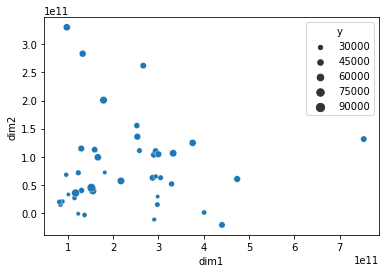

In [11]:
# Alternative à select_features --> PCA
from sklearn.decomposition import PCA
pca = PCA(n_components = 2) # 98% de la variance expliquée
pca.fit(extracted_features_df)

print("explained var : ",pca.explained_variance_ratio_.sum())
print("components shape : ",pca.components_.T.shape) # (326,2)
selected_features_df_pca = extracted_features_df @ pca.components_.T
print(selected_features_df_pca.shape)

selected_features_df_pca = np.concatenate((selected_features_df_pca, y.values.reshape(41,1)), axis = 1)
selected_features_df_pca = pd.DataFrame(selected_features_df_pca)
selected_features_df_pca.columns = ["dim1","dim2","y"]
sns.scatterplot(data = selected_features_df_pca, x = 'dim1', y = 'dim2', size = 'y')


<AxesSubplot:xlabel='dim1', ylabel='dim2'>

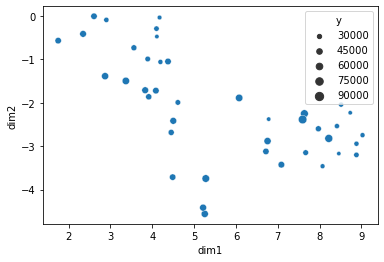

In [12]:
# Approche t-SNE
from sklearn.manifold import TSNE
tsne = TSNE(init='random', perplexity = 20)
selected_features_df_tsne = tsne.fit_transform(selected_features_df_pca)

selected_features_df_tsne = np.concatenate((selected_features_df_tsne, y.values.reshape(41,1)), axis = 1)
selected_features_df_tsne = pd.DataFrame(selected_features_df_tsne)
selected_features_df_tsne.columns = ["dim1","dim2","y"]
sns.scatterplot(data = selected_features_df_tsne, x = 'dim1', y = 'dim2', size = 'y')


In [14]:
# Régression ElasticNet - features issues de l'ACP
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
param_grid = {'l1_ratio': [0.1,0.2,0.3,0.4,0.5,0.6,0.8,0.9,1]}
scores_train = []
for param in param_grid["l1_ratio"]:
    mod = ElasticNet(l1_ratio = param, max_iter = 1000000, tol = 0.001)
    scores_train.append(cross_val_score(mod, tsne.embedding_, y.values, cv = 5, scoring = "r2").mean())
print(scores_train)

[-0.6831893181041226, -0.659718987623524, -0.6330215695252673, -0.6024474809309557, -0.567192596271328, -0.5262900433601034, -0.4235989485543888, -0.3622608452204608, -0.30552223496210235]


# Méthodes classiques --> pas performantes
Idée = entrainer des modèles sur les 2 ensemble de descripteurs obtenus (select_features ou PCA)

In [11]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn import linear_model
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.pipeline import make_pipeline
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import RandomForestRegressor

# X_train, X_test, y_train, y_test = train_test_split(selected_features_df, y, test_size=0.3, random_state=0)
# X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(selected_features_df_pca, y, test_size=0.3, random_state=0)

# # Régression ElasticNet - features de select_features
# param_grid = {'l1_ratio': [0,0.1,0.2,0.3,0.4,0.5,0.6,0.8,0.9,1]}
# scores_train = []
# for param in param_grid["l1_ratio"]:
#     mod = ElasticNet(l1_ratio = param, max_iter = 100000, tol = 1)
#     scores_train.append(cross_val_score(mod, X_train, y_train, cv = 5, scoring = "r2").mean())
# print(scores_train)

# Régression ElasticNet - features issues de l'ACP
# param_grid = {'l1_ratio': [0,0.1,0.2,0.3,0.4,0.5,0.6,0.8,0.9,1]}
# scores_train = []
# for param in param_grid["l1_ratio"]:
#     mod = ElasticNet(l1_ratio = param, max_iter = 1000000, tol = 0.001)
#     scores_train.append(cross_val_score(mod, X_train_pca, y_train_pca, cv = 5, scoring = "r2").mean())
# print(scores_train)


# Régression Lasso - features de select_features
# param_grid = {'alpha': [0,0.1,0.2,0.3,0.4,0.5,0.6,0.8,0.9,1]}
# scores_train = []
# for param in param_grid["alpha"]:
#     mod = ElasticNet(alpha = param,max_iter = 80000, tol = 0.1)
#     scores_train.append(cross_val_score(mod, X_train, y_train, cv = 5, scoring = "r2").mean())
# print(scores_train)

# Régression Lasso - vec features issues de l'ACP
# param_grid = {'alpha': [0.1,1,10,100]}
# scores_train = []
# for param in param_grid["alpha"]:
#     mod = linear_model.Lasso(alpha = param, max_iter = 1000000, tol =0.11)
#     scores_train.append(cross_val_score(mod, X_train_pca, y_train_pca, cv = 5, scoring = "r2").mean())
# print(scores_train)


# Régression PLS - features de select_features
# scores_train = []
# param_grid = {'n_components': [1,2,3,4,5,6]}
# for param in param_grid["n_components"]:
#     pls = PLSRegression(n_components = param ,max_iter = 10000, tol = 0.01)
#     scores_train.append(cross_val_score(pls, X_train, y_train, cv = 5, scoring = "r2").mean())
# print(scores_train)

# Random Forest Regressor
# scores_train = []
# param_grid = {'criterion': ["squared_error", "absolute_error", "friedman_mse", "poisson"]}
# for param in param_grid["criterion"]:
#     rfr = RandomForestRegressor(criterion = param)
#     scores_train.append(cross_val_score(rfr, X_train, y_train, cv = 5, scoring = "r2").mean())
# print(scores_train)

# SVR
# scores_train = []
# param_grid = {'C': [0.01, 1, 100]}
# for param in param_grid["C"]:
#     print(param)
#     svr = SVR(C = param, gamma = 'auto')
#     scores_train.append(cross_val_score(svr, X_train, y_train, cv = 5, scoring = "r2").mean())
# print(scores_train)

# KNN
# scores_train = []
# param_grid = {'n_neighbors': [1,5,10,15]}
# for param in param_grid["n_neighbors"]:
#     print(param)
#     knn = KNeighborsRegressor(n_neighbors = param)
#     scores_train.append(cross_val_score(knn, X_train, y_train, cv = 5, scoring = "r2").mean())
# print(scores_train)

# Approche Deep --> TimeNet

In [12]:
from tensorflow import keras
from keras.models import load_model
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from TimeNet.timenet import TimeNet, SimpleSeriesGenerator, normalize_series
encoder = load_model('/Users/etienneperez/Documents/IODAA/Projet fil rouge/TimeNet/models/64_x3_drop40_model/timenet_encoder.h5',
compile = False) # compile=False empêche d'utiliser fit() ensuite = cas où on veut juste utiliser le modèle sans entrainer

# Restructuration des inputs pour qu'elles aient le mm format que celles données en input de l'encoder
df.date = pd.to_datetime(df.date)
df = df.sort_values(["parcelle","date"], ascending = True)
my_series = df[['parcelle', 'ndvi']].groupby(by='parcelle')['ndvi'].apply(np.array)
my_series = pd.DataFrame({'series': my_series, 'y' : y.values, 'length': my_series.apply(len)}) \
    .sort_values(by='length', ascending=False) \
    .reset_index()
my_maxlen = my_series['length'].max()
my_data_X = my_series['series']
my_data_y = my_series["y"]
X_train, X_test, y_train, y_test = train_test_split(my_data_X, my_data_y, test_size=0.25, random_state=0)

# On encode tout en embeddings avec l'encoder récupéré
generator_train = SimpleSeriesGenerator(X_train, batch_size=5, X_only=True, maxlen = my_maxlen) # Regarder len(generator) pour voir cb de batchs on va pouvoir faire
generator_test = SimpleSeriesGenerator(X_test, batch_size=1, X_only=True, maxlen = my_maxlen)

embeddings_train = encoder.predict(generator_train, verbose = True)
embeddings_test = encoder.predict(generator_test, verbose = True)

/Users/etienneperez/Documents/IODAA/Projet fil rouge/TimeNet/timenet.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.array([x for x in X if x is not None])


11/11 [==============================] - 0s 13ms/step


In [13]:
print(embeddings_train.shape, embeddings_test.shape)


(30, 192) (11, 192)


explained var :  0.98447216
components shape :  (192, 2)
(30, 192)


<AxesSubplot:xlabel='dim1', ylabel='dim2'>

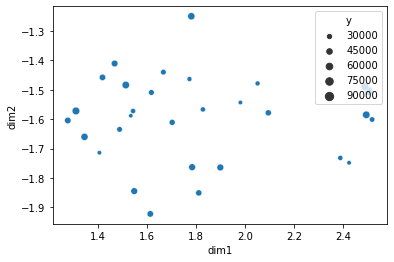

In [14]:
# PCA : on tente une PCA pr visualiser les embeddings obtenus
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
pca = PCA(n_components = 2) # 99% de la variance expliquée
pca.fit(embeddings_train)

print("explained var : ",pca.explained_variance_ratio_.sum())
print("components shape : ",pca.components_.T.shape) # (192,2)
print(embeddings_train.shape) # (30, 192)
embeddings_train_pca = embeddings_train @ pca.components_.T
embeddings_train_pca.shape # (30,2)

embeddings_train_pca = np.concatenate((embeddings_train_pca, y_train.values.reshape(30,1)), axis = 1)
embeddings_train_pca = pd.DataFrame(embeddings_train_pca)
embeddings_train_pca.columns = ["dim1","dim2","y"]
sns.scatterplot(data = embeddings_train_pca, x = 'dim1', y = 'dim2', size = 'y')
# --> Représentation non pertinente

<AxesSubplot:xlabel='dim1', ylabel='dim2'>

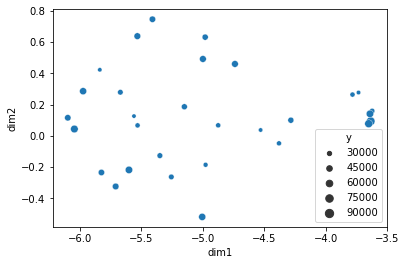

In [44]:
# t-SNE --> visualiser les embeddings
from sklearn.manifold import TSNE
tsne = TSNE(init='random', perplexity = 25)
embeddings_train_tsne = tsne.fit_transform(embeddings_train_pca[["dim1","dim2"]])

embeddings_train_tsne = np.concatenate((embeddings_train_tsne, y_train.values.reshape(30,1)), axis = 1)
embeddings_train_tsne = pd.DataFrame(embeddings_train_tsne)
embeddings_train_tsne.columns = ["dim1","dim2","y"]
sns.scatterplot(data = embeddings_train_tsne, x = 'dim1', y = 'dim2', size = 'y')

In [133]:
# Linear Regression pr avoir les poids de : peuplement = w1 * dim1 + w2 * dim2
from sklearn.linear_model import LinearRegression

mod = LinearRegression()
mod.fit(embeddings_train_tsne[["dim1","dim2"]], embeddings_train_tsne["y"])
print(r2_score(mod.predict(embeddings_train_tsne[["dim1","dim2"]]),embeddings_train_tsne["y"]))
print(mod.coef_)
print(mod.intercept_)



0.9572189291936934
[4615.6603101  5132.90450359]
40025.721727892174


In [131]:
embeddings_train_tsne

,dim1,dim2,y
0,-1.886314,0.974108,38181.818182
1,-0.234588,3.598229,54800.000000
2,-1.483976,0.737559,38000.000000
3,-0.211253,3.858577,56000.000000
4,-0.762828,2.674330,49333.333334
5,-0.123736,3.797781,56000.000000
6,-1.332386,1.690225,43666.666666
7,-1.975204,0.915041,37666.666668
8,1.011047,5.878394,75600.000000
9,0.209806,4.651740,61600.000000


In [66]:
# SVR sur les embeddings
# scores_train = []
# param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
# for param in param_grid["C"]:
#     print(param)
#     svr = SVR(kernel = 'sigmoid', C = param)
#     scores_train.append(cross_val_score(svr, embeddings_train_pca[["dim1","dim2"]], y_train, cv = 5, scoring = "r2").mean())
# print(scores_train)

# KNN
scores_train = []
param_grid = {'n_neighbors': [1,5,10,15]}
for param in param_grid["n_neighbors"]:
    print(param)
    knn = KNeighborsRegressor(n_neighbors = param)
    scores_train.append(cross_val_score(knn, embeddings_train_tsne[["dim1","dim2"]], y_train, cv = 5, scoring = "r2").mean())
print(scores_train)


1
5
10
15
[0.9500001028784617, 0.9261910092308717, 0.8443970820499553, 0.6714368635076949]


In [53]:
y_train.shape

(30,)

In [143]:
class MLP(nn.Module): # Multi Layer Perceptron
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Linear(192, 2),
      nn.ReLU(),
      # nn.Linear(96, 40),
      # nn.ReLU(),
      # nn.Linear(40, 2),
      # nn.ReLU(),
      nn.Linear(2, 1)
    )
    self.double()
  def forward(self, x):
    return self.layers(x)

net = MLP()
net.layers[2]
# with torch.no_grad():
#   net.layers[6].weight = torch.nn.Parameter(torch.tensor([[4615.], [5133.]]))
#   net.layers[6].bias = torch.nn.Parameter(torch.tensor([40025.]))
#   net.layers[6].requires_grad_(False)

Linear(in_features=2, out_features=1, bias=True)

In [155]:
print(embeddings_train.shape)

(30, 192)


In [167]:
# Decoder = branchement d'un perceptron multi couches
import torch
import torch.nn as nn
from torch.utils.data import DataLoader,TensorDataset
from torch.utils.tensorboard import SummaryWriter
import time
import os
%load_ext tensorboard
%tensorboard --logdir /tmp/logs

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

def save_state(epoch,model,optim,fichier):
  state = {'epoch' : epoch, 'model_state': model.state_dict(), 'optim_state': optim.state_dict()}
  torch.save(state,fichier)

def load_state(fichier,model,optim):
  epoch = 0
  if os.path.isfile(fichier):
    state = torch.load(fichier)
    model.load_state_dict(state['model_state'])
    optim.load_state_dict(state['optim_state'])
    epoch = state['epoch']
  return epoch

class MLP(nn.Module): # Multi Layer Perceptron
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Linear(192, 96),
      nn.ReLU(),
      nn.Linear(96, 2),
      nn.ReLU(),
      # nn.Linear(40, 2),
      # nn.ReLU(),
      nn.Linear(2, 1)
    )
    self.double()
  def forward(self, x):
    return self.layers(x)


train_data = TensorDataset(torch.tensor(embeddings_train),torch.tensor(y_train.values))

train_size = int(0.8 * len(train_data))
validate_size = len(train_data) - train_size
train_data, valid_data = torch.utils.data.random_split(train_data, [train_size, validate_size])

EPOCHS = 70000
BATCH_SIZE = 5

train_loader = DataLoader(train_data,batch_size=BATCH_SIZE,shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=BATCH_SIZE)

net = MLP()
with torch.no_grad():
  net.layers[4].weight = torch.nn.Parameter(torch.tensor([[4615., 5133.]]).to(torch.float64))
  net.layers[4].bias = torch.nn.Parameter(torch.tensor([40025.]).to(torch.float64))
  net.layers[4].requires_grad_(False)
net.name = "decoder_mlp"
CHECK_FILE = "/tmp/decoder_mlp.chk"
net = net.to(device)

# mlp = MLP()
loss_function = nn.L1Loss()
# loss_function = nn.MSELoss()
# loss_function = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-4)
optim = torch.optim.SGD(params=net.parameters(),lr=1e-1)


summary = SummaryWriter(f"/tmp/logs/model-{time.asctime()}")
for epoch in range(EPOCHS):
  # Apprentissage
  # .train() inutile tant qu'on utilise pas de normalisation ou de récurrent
  net.train()
  cumloss = 0
  for xbatch, ybatch in train_loader:
    xbatch, ybatch = xbatch.to(device), ybatch.to(device)
    xbatch = xbatch.to(torch.float64)
    outputs = net(xbatch)
    loss = loss_function(outputs.view(-1),ybatch)
    optim.zero_grad()
    loss.backward()
    optim.step()
    cumloss += loss.item()
  summary.add_scalar("loss/train loss",  cumloss/len(train_loader),epoch)
    
  if epoch % 10 == 0: 
    save_state(epoch,net,optim,CHECK_FILE)
    # Validation
    # .eval() inutile tant qu'on utilise pas de normalisation ou de récurrent
    net.eval()
    with torch.no_grad():
      cumloss = 0
      for xbatch, ybatch in valid_loader:
        xbatch, ybatch = xbatch.to(device), ybatch.to(device)
        xbatch = xbatch.to(torch.float64)
        outputs = net(xbatch)
      cumloss += loss_function(outputs.view(-1),ybatch).item()
    summary.add_scalar("loss/validation loss", cumloss/len(valid_loader) ,epoch)



The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 5935), started 4:24:46 ago. (Use '!kill 5935' to kill it.)

In [168]:
# Perf en train
outputs = net(torch.tensor(embeddings_train).to(torch.float64))
print(outputs.view(-1))
print(y_train.values)
print(r2_score(outputs.detach().numpy(),y_train.values))

tensor([40025., 40025., 40025., 40025., 40025., 40025., 40025., 40025., 40025.,
        40025., 40025., 40025., 40025., 40025., 40025., 40025., 40025., 40025.,
        40025., 40025., 40025., 40025., 40025., 40025., 40025., 40025., 40025.,
        40025., 40025., 40025.], dtype=torch.float64, grad_fn=<ViewBackward0>)
[38181.818182   54800.         38000.         56000.
 49333.333334   56000.         43666.666666   37666.666668
 75600.         61600.         36416.66666665 94000.
 60555.555555   30000.000001   71600.         50400.
 67200.         41200.         43600.         62000.
 68000.         30000.         82000.         45454.545456
 29090.90909    35166.66666667 52000.         58800.
 72000.         30222.22222222]
0.0


In [169]:
# Perf en test
outputs = net(torch.tensor(embeddings_test).to(torch.float64))
print(outputs.view(-1))
print(y_test.values)

tensor([40025., 40025., 40025., 40025., 40025., 40025., 40025., 40025., 40025.,
        40025., 40025.], dtype=torch.float64, grad_fn=<ViewBackward0>)
[56000.         68000.         41200.         79600.
 36952.38095229 57600.         48400.         56800.
 39200.         64400.         33200.        ]


In [101]:
loss_function(outputs.view(-1),torch.tensor(y_test.values).to(torch.float64))

tensor(12073.4277, dtype=torch.float64, grad_fn=<MeanBackward0>)

In [75]:
embeddings_train.shape

(30, 192)

In [33]:
# Entrainement à partir des dim obtenues en PCA suivie d'un t-SNE
# tsne.embedding_
# Régression ElasticNet - features issues de l'ACP
from sklearn.linear_model import LinearRegression, ElasticNet
param_grid = {'l1_ratio': [0.1,0.2,0.3,0.4,0.5,0.6,0.8,0.9,1]}
scores_train = []
for param in param_grid["l1_ratio"]:
    mod = ElasticNet(l1_ratio = param, max_iter = 1000000, tol = 0.001)
    scores_train.append(cross_val_score(mod, tsne.embedding_, y_train, cv = 5, scoring = "r2").mean())
print(scores_train)


[0.9387603933465453, 0.9413030474333797, 0.9435034119292025, 0.9453256234704119, 0.9467302165365403, 0.9476733041959806, 0.9479724478764024, 0.9471981213220874, 0.9453687024924775]


In [41]:
# Perf en test
from sklearn.metrics import mean_squared_error,r2_score
tsne = TSNE(init='random', perplexity = 15)
embeddings_train_tsne = tsne.fit_transform(embeddings_train_pca)

mod = ElasticNet(l1_ratio = 0.5, max_iter = 1000000, tol = 0.001)
mod.fit(tsne.embedding_,y_train)

embeddings_test_pca = embeddings_test @ pca.components_.T
tsne = TSNE(init='random', perplexity = 5)
embeddings_test_tsne = tsne.fit_transform(embeddings_test_pca)

print(r2_score(mod.predict(tsne.embedding_),y_test))






-0.06742892023498515
